In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.8.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

| #Values | Names      | Description                                                                                                                |
|---------|------------|----------------------------------------------------------------------------------------------------------------------------|
| 1       | type       | Describes the type of object: 'Car', 'Van', 'Truck','Pedestrian', 'Person_sitting', 'Cyclist', 'Tram','Misc' or 'DontCare' |
| 1       | truncated  | Float from 0 (non-truncated) to 1 (truncated),                                                                             |
| 1       | occluded   | 0 = fully visible, 1 = partly occluded, 2 = largely occluded, 3 = unknown                                                  |
| 1       | alpha      | Observation angle                                                                                                          |
| 4       | bbox       | left, top, right, bottom pixel coordinates                                                                                 |
| 3       | dimensions | 3D object dimensions: height, width, length (in meters)                                                                    |
| 3       | location   | 3D object location x,y,z in camera coordinates (in meters)                                                                 |
| 1       | rotation_y | Rotation ry around Y-axis in camera coordinates [-pi..pi]                                                                  |
| 1       | score      | Only for results: Float, indicating confidence in detection, needed for p/r curves, higher is better.                      |

In [ ]:
Example:

Car 0.60 3 -2.42 0.00 185.93 214.05 348.86 1.56 1.57 4.37 -6.96 1.73 7.83 -3.13

# Register KITTI dataset

In [ ]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

import os
import pandas as pd
from detectron2.structures import BoxMode

def get_kitti_dicts(kitti_dir, indices=range(500)):
  classes = ('Car', 'Van', 'Truck','Pedestrian', 'Person_sitting', 'Cyclist', 'Tram','Misc', 'DontCare')
  cols = ('type', 'truncated', 'occluded', 'alpha', 'left', 'top', 'right',
      'bottom', 'height', 'width', 'length', 'x', 'y', 'z', 'rot_y','score')

  record = {} #Dict with image info for the dataset

  dataset_dicts = []
  for idx in indices:
      img_path = os.path.join(kitti_dir, 'data_object_image_2', 'training', 'image_2', str(idx).zfill(6)+'.png')
      labels_path = os.path.join(kitti_dir, 'training', 'label_2', str(idx).zfill(6)+'.txt')
      
      im = cv2.imread(img_path)
      if im is None:
        continue
      height, width = im.shape[:2]

      record = {}
      record["file_name"] = img_path
      record["image_id"] = idx
      record["height"] = height
      record["width"] = width

      objs = []

      dtf = pd.read_csv(labels_path, delimiter=' ', names=cols)     
      for i, row in dtf.iterrows():
          # Accessing all available info
          # obj = {
          # 'type': row.type,
          # 'truncated': row.truncated,
          # 'occluded': row.occluded,
          # 'alpha': row.alpha,
          # 'bbox': (row.left, row.top, row.right, row.bottom),
          # 'dims': (row.height, row.width, row.length),
          # 'pos': (row.x, row.y, row.z),
          # 'rot_y': row.rot_y,
          # 'score': row.score
          # }
          # objs.append(obj)
          if row.type not in ['Car', 'Van', 'Truck']: 
            continue
  
          # Add filters on truncated, occluded and maybe size?
          obj = {
            "bbox": [row.left, row.top, row.right, row.bottom],
            "bbox_mode": BoxMode.XYXY_ABS,
            "category_id": classes.index(row.type),
          }
          objs.append(obj)
      record["annotations"] = objs
      dataset_dicts.append(record)
      
  return dataset_dicts
  '''
    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y -lesscin zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts
  '''

# get_kitti_dicts('/content/drive/MyDrive/Datasets/KITTI')

# for d in ["train", "val"]:
#     DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts("balloon/" + d))
#     MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])
# balloon_metadata = MetadataCatalog.get("balloon_train")
ds_name = 'kitti-5k-vehicles'
classes = ('Car', 'Van', 'Truck')#,'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram','Misc', 'DontCare')
DatasetCatalog.register(ds_name + "-train", lambda : get_kitti_dicts('/content/drive/MyDrive/Datasets/KITTI', range(4000)))
MetadataCatalog.get(ds_name + "-train").set(thing_classes=classes )

DatasetCatalog.register(ds_name + "-test", lambda : get_kitti_dicts('/content/drive/MyDrive/Datasets/KITTI', range(4000, 5000)))
MetadataCatalog.get(ds_name + "-test").set(thing_classes=classes )

kitti_metadata = MetadataCatalog.get(ds_name + "-train")

AssertionError: ignored

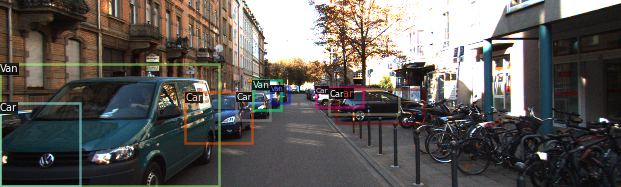

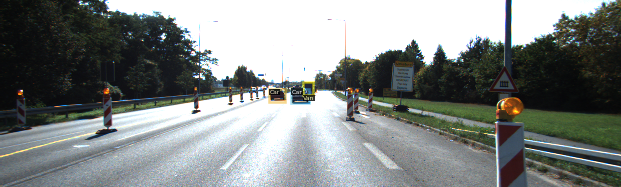

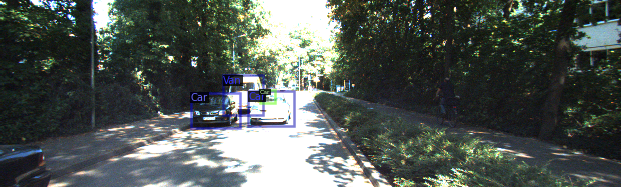

In [ ]:
# Randomly visualize ds
# dataset_dicts = get_kitti_dicts('/content/drive/MyDrive/Datasets/KITTI')
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=kitti_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
# Train
from detectron2.engine import DefaultTrainer
classes = ('Car', 'Van', 'Truck')#,'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram','Misc', 'DontCare')

mzoo_config_file = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
mzoo_config_file = "COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"
mzoo_config_file = "COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"
mzoo_config_file = "COCO-Detection/faster_rcnn_R_101_DC5_3x.yaml"

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(mzoo_config_file))
cfg.DATASETS.TRAIN = (ds_name + "-train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(mzoo_config_file)  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)  


In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

[03/15 02:40:38 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in th

In [ ]:
trainer.train()

[03/15 02:42:00 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[03/15 02:42:58 d2.utils.events]:  eta: 0:13:21  iter: 19  total_loss: 1.848  loss_cls: 1.46  loss_box_reg: 0.3331  loss_rpn_cls: 0.02258  loss_rpn_loc: 0.01453  time: 2.8603  data_time: 0.0651  lr: 4.9953e-06  max_mem: 11092M
[03/15 02:43:57 d2.utils.events]:  eta: 0:12:38  iter: 39  total_loss: 1.808  loss_cls: 1.364  loss_box_reg: 0.401  loss_rpn_cls: 0.02212  loss_rpn_loc: 0.01423  time: 2.9213  data_time: 0.0406  lr: 9.9902e-06  max_mem: 11092M
[03/15 02:44:59 d2.utils.events]:  eta: 0:11:56  iter: 59  total_loss: 1.636  loss_cls: 1.166  loss_box_reg: 0.4051  loss_rpn_cls: 0.02449  loss_rpn_loc: 0.01506  time: 2.9745  data_time: 0.0474  lr: 1.4985e-05  max_mem: 11092M
[03/15 02:46:02 d2.utils.events]:  eta: 0:11:05  iter: 79  total_loss: 1.327  loss_cls: 0.9292  loss_box_reg: 0.3928  loss_rpn_cls: 0.02263  loss_rpn_loc: 0.01736  time: 3.0205  data_time: 0.0482  lr: 1.998e-05  max_mem: 11092M
[03/15 02:47:05 d2.utils.events]:  eta: 0:10:13  iter: 99  total_loss: 1.164  loss_cls: 0.

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

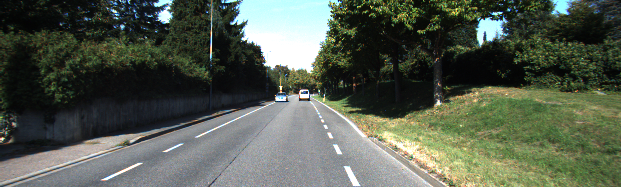

{'instances': Instances(num_instances=0, image_height=375, image_width=1242, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64)])}


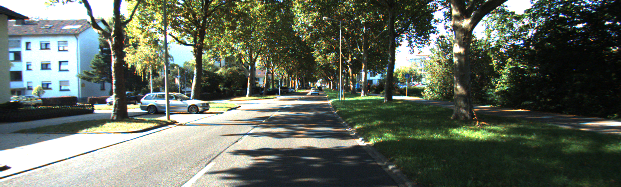

{'instances': Instances(num_instances=0, image_height=375, image_width=1242, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64)])}


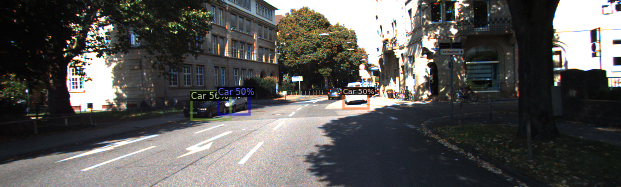

{'instances': Instances(num_instances=3, image_height=375, image_width=1242, fields=[pred_boxes: Boxes(tensor([[381.2101, 183.6996, 460.8029, 238.7031],
        [435.8172, 176.0434, 497.5052, 228.1662],
        [685.0421, 177.1195, 736.6680, 217.1820]], device='cuda:0')), scores: tensor([0.5635, 0.5037, 0.5036], device='cuda:0'), pred_classes: tensor([0, 0, 0], device='cuda:0')])}


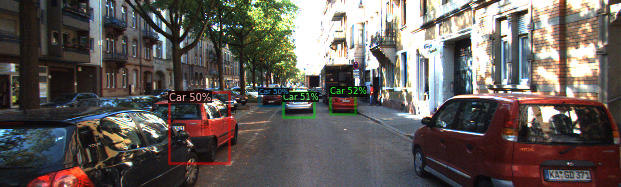

{'instances': Instances(num_instances=4, image_height=375, image_width=1242, fields=[pred_boxes: Boxes(tensor([[659.6992, 174.9209, 710.2925, 228.7054],
        [565.9009, 185.3817, 627.9257, 235.8065],
        [337.3385, 185.1273, 458.3369, 326.7341],
        [518.0628, 177.7671, 569.4337, 213.7725]], device='cuda:0')), scores: tensor([0.5199, 0.5146, 0.5047, 0.5043], device='cuda:0'), pred_classes: tensor([0, 0, 0, 0], device='cuda:0')])}


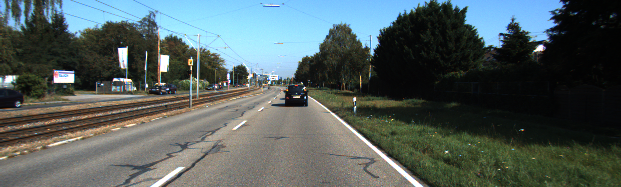

{'instances': Instances(num_instances=0, image_height=375, image_width=1242, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64)])}


In [ ]:
# Rnadomly visualize results
from detectron2.utils.visualizer import ColorMode
# dataset_dicts = get_kitti_dicts('/content/drive/MyDrive/Datasets/KITTI')
for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=kitti_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

    print(outputs)

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator(ds_name + "-test", ("bbox",), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg,ds_name + "-test")
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[03/15 03:01:04 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/15 03:01:04 d2.data.common]: Serializing 1000 elements to byte tensors and concatenating them all ...
[03/15 03:01:04 d2.data.common]: Serialized dataset takes 0.45 MiB
[03/15 03:01:04 d2.evaluation.evaluator]: Start inference on 1000 images


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[03/15 03:01:06 d2.evaluation.evaluator]: Inference done 11/1000. 0.1763 s / img. ETA=0:02:55
[03/15 03:01:11 d2.evaluation.evaluator]: Inference done 40/1000. 0.1760 s / img. ETA=0:02:50
[03/15 03:01:16 d2.evaluation.evaluator]: Inference done 68/1000. 0.1766 s / img. ETA=0:02:46
[03/15 03:01:21 d2.evaluation.evaluator]: Inference done 96/1000. 0.1771 s / img. ETA=0:02:41
[03/15 03:01:26 d2.evaluation.evaluator]: Inference done 124/1000. 0.1775 s / img. ETA=0:02:37
[03/15 03:01:32 d2.evaluation.evaluator]: Inference done 152/1000. 0.1779 s / img. ETA=0:02:32
[03/15 03:01:37 d2.evaluation.evaluator]: Inference done 180/1000. 0.1784 s / img. ETA=0:02:27
[03/15 03:01:42 d2.evaluation.evaluator]: Inference done 208/1000. 0.1789 s / img. ETA=0:02:23
[03/15 03:01:47 d2.evaluation.evaluator]: Inference done 236/1000. 0.1791 s / img. ETA=0:02:18
[03/15 03:01:52 d2.evaluation.evaluator]: Inference done 264/1000. 0.1794 s / img. ETA=0:02:13
[03/15 03:01:57 d2.evaluation.evaluator]: Inference do

In [ ]:
trainer.test